In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Open CSV file

In [10]:
# load csv file into pandas dataframe
df = pd.read_csv('Simulation Result Example.csv')

# sort by producer_record_start
df.sort_values(by=['producer_record_start'], inplace=True)

print(len(df))
df.head(5)

12400


,conn_id,e2e_latency_ms,producer_latency_ms,consumer_latency_ms,producer_record_start,producer_record_end,consumer_record_start,consumer_record_end
13,7874fcfe-a484-4fe9-b9cb-7b7b1750e9ba,5938,5439,82,1723558398873,1723558404312,1723558404729,1723558404811
7,8cdefa66-ecb7-414d-9207-b22c3cfe850d,6077,5224,80,1723558398873,1723558404097,1723558404870,1723558404950
3,9dba574b-3cac-40c8-82ac-58775026c50e,6205,5140,78,1723558398884,1723558404024,1723558405011,1723558405089
22,8cf8c348-bcd1-41c8-af4a-f1fe54c4c5ae,5595,5045,123,1723558398885,1723558403930,1723558404357,1723558404480
25,61ee470c-08b4-4f5e-8dca-bee4dc1e6038,5359,4814,97,1723558398885,1723558403699,1723558404147,1723558404244


## 2. e2e latency plot

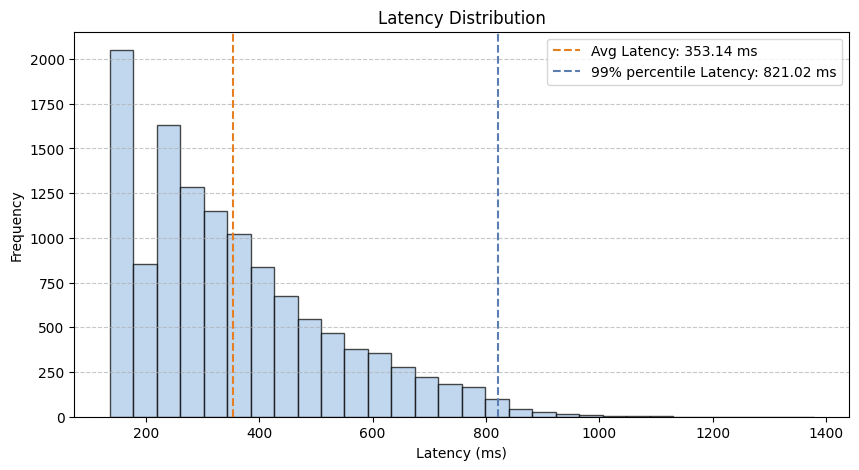

In [11]:
series = df.e2e_latency_ms
series = series[101:] # Matches the number of requests (from the moment all users have entered)
percentile = series.quantile(0.99)
mean_val = series.mean()

# Draw histogram
plt.figure(figsize=(10, 5))
plt.hist(series, bins=30, color='#A7C7E7', alpha=0.7, edgecolor='black')

# Add average and 99% percentile line
plt.axvline(mean_val, color='#E67E22', linestyle='--', label=f'Avg Latency: {mean_val:.2f} ms')
plt.axvline(percentile, color='#5B7DB1', linestyle='--', label=f'99% percentile Latency: {percentile:.2f} ms')

# Add legend, title, grid
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.title('Latency Distribution')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

## 3. Consumer throughput plot

In [12]:
# aggregate by seconds of consumer_record_start and count the number of records
# which is in milliseconds, so we need to divide the series by 1000 to get the seconds
series = df.consumer_record_end
series = series // 1000
series = series - min(series)

series

# now, group by the seconds and count the number of records
series = series.groupby(series).count().sort_index()
# series = series[6:-1]

<ipython-input-13-822562f8ba55>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  throughput_avg = new_df.groupby('time_bin')['timestamp'].count() / 5  # Compute average throughput per second (events per second)


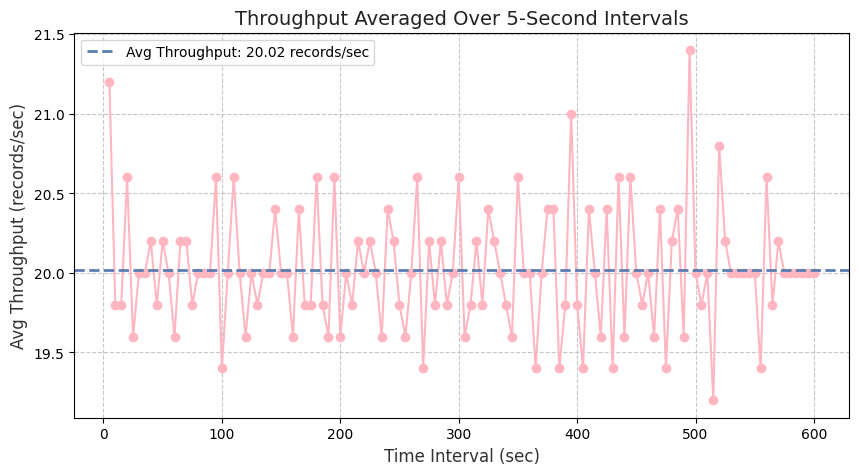

In [13]:
# Sample timestamp data (in seconds, needs sorting)
timestamps = df.consumer_record_end[105:]
timestamps = np.sort(timestamps) # Sort timestamps in ascending order
timestamps = timestamps - min(timestamps) # Normalize timestamps to start from 0

# Create 5-second interval bins for averaging
bin_edges = np.arange(0, max(timestamps) / 1000 + 5, 5)  # Generate bins in 5-second increments

# Create a Pandas DataFrame and map timestamps to bins
new_df = pd.DataFrame({'timestamp': timestamps / 1000}) # Convert timestamps to seconds
new_df['time_bin'] = pd.cut(new_df['timestamp'], bins=bin_edges, right=False) # Assign each timestamp to a bin

# Count the number of events in each bin → Calculate average throughput per second
throughput_avg = new_df.groupby('time_bin')['timestamp'].count() / 5  # Compute average throughput per second (events per second)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(bin_edges[1:-3], throughput_avg[:-3], marker='o', linestyle='-', color='#FFB6C1')

# add average line
average_throughput = np.mean(throughput_avg[:-3])
plt.axhline(y=average_throughput, color='#5B7DB1', linestyle='--', linewidth=2, label=f'Avg Throughput: {average_throughput:.2f} records/sec')

# add legend, title, grid
plt.xlabel('Time Interval (sec)', fontsize=12, color='#333333')
plt.ylabel('Avg Throughput (records/sec)', fontsize=12, color='#333333')
plt.title('Throughput Averaged Over 5-Second Intervals', fontsize=14, color='#222222')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# show plot
plt.show()

## 4. CDF of E2E latency

In [14]:
def get_cdf(series: pd.Series):
    data_sorted = np.sort(series)
    cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    return data_sorted, cdf

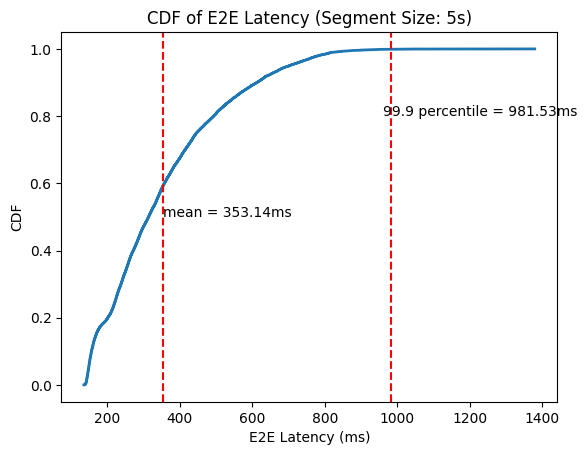

In [15]:
# e2e latency, clip the first 10000 records
series = df.e2e_latency_ms
series = series[101:]

# plot the cdf
data_sorted, cdf = get_cdf(series)
plt.plot(data_sorted, cdf, marker='None', linestyle='-', linewidth=2)

# compute the 99.9 percentile
upper_bound = series.quantile(0.999)
plt.axvline(x=upper_bound, color='r', linestyle='--', label='99.9 percentile')
plt.text(x=upper_bound - 20, y = 0.8, s=f"99.9 percentile = {upper_bound:.2f}ms")

# compute the mean
mean_val = series.mean()
plt.axvline(x=mean_val, c='r', linestyle='--')
plt.text(x=mean_val, y = 0.5, s=f"mean = {mean_val:.2f}ms")

plt.title('CDF of E2E Latency (Segment Size: 5s)')
plt.xlabel('E2E Latency (ms)')
plt.ylabel('CDF')

plt.show()